# Convolutional Neural Network

## Packages

In [3]:
# ----- Tensorflow -----
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras import optimizers as opt

# ----- Transfer learning -----
from keras.applications import NASNetLarge
from keras.applications import EfficientNetB0
from keras.applications import MobileNetV2

# ----- plot -----
import matplotlib.pyplot as plt
from keras.utils import plot_model

# ----- Utility functions -----
from utils import load_data, plot_hist, plot_hist_sideways, _convert_sample, get_features_and_labels, preprocess_data, augment_layer

# ------ Data ------
import numpy as np


# ----- ACTIVATION MAPS -------
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import cv2







Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


## Load Data

In [4]:
data_dir = r'C:\Users\andly'
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=1, batch_size=BATCH_SIZE)

In [5]:
# Hyperparams
EPOCHS = 2
LEARNING_RATE = 0.001
OPTIMIZER = opt.Nadam(learning_rate = LEARNING_RATE)

In [6]:
# Layers for feature extraction
mobilev2_ft_extractor = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
mobilev2_ft_extractor.trainable = False

In [7]:
# Build classifer
inputs = Input(shape = (96, 96, 3))
#x = augment_layer(flip = "horizontal_and_vertical", rotation=0.5, zoom = 0.4, contrast = 0.5)(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = mobilev2_ft_extractor(inputs)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobile_layer = Model(inputs = inputs, outputs = output)

# Compile model
m_mobile_layer.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

In [8]:
m_mobile_layer.fit(train, validation_data= val, epochs = EPOCHS)

Epoch 1/2
82/82 [==============================] - 23s 112ms/step - loss: 0.6030 - accuracy: 0.7585 - val_loss: 0.3305 - val_accuracy: 0.8598
Epoch 2/2
82/82 [==============================] - 2s 26ms/step - loss: 0.3347 - accuracy: 0.8436 - val_loss: 0.3300 - val_accuracy: 0.8659


In [9]:
def return_x(x):
    return x

# Load an image
images, labels = preprocess_data(train, return_x)


# Create a GradientTape to record the operations to compute the gradients
with tf.GradientTape() as tape:
    # Run a forward pass on your model to obtain the predictions
    inputs = np.zeros((1, 96, 96, 3))  # Example input tensor with shape (batch_size, height, width, channels)
    tape.watch(inputs)
    predictions = model(inputs)

    # Choose the class index to visualize the heatmap for
    class_index = np.argmax(predictions[0])

# Compute the gradients of the output with respect to the input image
gradients = tape.gradient(predictions[0][class_index], inputs)

# Normalize the gradients to visualize the heatmap
gradients /= tf.math.reduce_std(gradients) + 1e-5

# Overlay the heatmap on the input image
heatmap = np.uint8(255 * gradients / np.max(gradients))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

# Plot the resulting image
plt.imshow(heatmap[0])
plt.axis('off')
plt.show()


ValueError: Passed in object [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]] of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [24]:
# Get the prediction
preds = m_mobile_layer.predict(x)
class_idx = np.argmax(preds[0])
class_output = m_mobile_layer.output[:, class_idx]

1/1 [==============================] - 2s 2s/step


In [28]:
# Compute the gradients of the class output value with respect to the feature map
last_conv_layer = m_mobile_layer.get_layer("dense_3")
grads = keras.backend.tf.GradientTape(class_output, last_conv_layer.output)[0]
pooled_grads = keras.backend.mean(grads, axis=(0, 1, 2))

AttributeError: module 'keras.api._v2.keras.backend' has no attribute 'tf'

# Transfer Learning
- Discuss and apply transfer learning. Motivate what type of transfer learning you use and how you apply it, including considerations for how to prepare the data for this. Here, be sure to visualize plots of train and validation losses and accuracies.



#### MobileNet V2

## Feature Extraction - 1 pass
For the feature extraction approach, we will utilize a large network, since we do not have to train it, we can utilize its size and save computational ressources. In this case we are using NasNetLarge, since it is one of the best performing models in terms of accuracy for image classification. However, it is a HUGE model, and will take time to even load.
However, we will also try with mobilenet v2 since it has been trained on 96 x 96 pixel images

### Helper Functions

### Build Feature Extractor with NasNet Large

#### Feature Extractor

In [4]:
# Initilize NasNetLarge Feature Extractor
NasNet_ft_extractor = NASNetLarge(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
NasNet_ft_extractor.trainable = False

#### Classifier

In [5]:
# Build classifer
x = NasNet_ft_extractor.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_nasnet = Model(inputs = NasNet_ft_extractor.output, outputs = output)

# Compile model
m_nasnet.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [6]:
# X features
nasnet_fts_train, y_train = get_features_and_labels(train, NasNet_ft_extractor, tf.keras.applications.efficientnet.preprocess_input)
nasnet_fts_val, y_val = get_features_and_labels(val, NasNet_ft_extractor, tf.keras.applications.efficientnet.preprocess_input)

1/1 [==============================] - 0s 409ms/step


#### Train model with Nasnet Features

In [7]:
history_nasnet = m_nasnet.fit(x = nasnet_fts_train, y = y_train, validation_data = (nasnet_fts_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)


Epoch 1/50
820/820 [==============================] - 49s 58ms/step - loss: 0.5261 - accuracy: 0.7489 - val_loss: 0.5060 - val_accuracy: 0.7394
Epoch 2/50
820/820 [==============================] - 46s 56ms/step - loss: 0.3949 - accuracy: 0.8237 - val_loss: 0.5512 - val_accuracy: 0.7309
Epoch 3/50
820/820 [==============================] - 45s 55ms/step - loss: 0.2898 - accuracy: 0.8759 - val_loss: 0.6664 - val_accuracy: 0.7101
Epoch 4/50
820/820 [==============================] - 45s 55ms/step - loss: 0.2100 - accuracy: 0.9208 - val_loss: 0.6631 - val_accuracy: 0.7360
Epoch 5/50
820/820 [==============================] - 45s 55ms/step - loss: 0.1318 - accuracy: 0.9512 - val_loss: 0.8369 - val_accuracy: 0.7168
Epoch 6/50
820/820 [==============================] - 46s 56ms/step - loss: 0.0827 - accuracy: 0.9728 - val_loss: 1.0834 - val_accuracy: 0.7193
Epoch 7/50
820/820 [==============================] - 45s 55ms/step - loss: 0.0501 - accuracy: 0.9870 - val_loss: 1.1951 - val_accuracy:

### Feature extractor with MobileNetV2

#### Feature Extractor

#### Classifier

In [9]:
# Full model
x = mobilev2_ft_extractor.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobilev2 = Model(inputs = mobilev2_ft_extractor.output, outputs = output)

# Compile model
m_mobilev2.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [10]:
# Extract Features
mobilev2_fts_train, y_train = get_features_and_labels(train, mobilev2_ft_extractor, tf.keras.applications.mobilenet_v2.preprocess_input)
mobilev2_fts_val, y_val = get_features_and_labels(val, mobilev2_ft_extractor, tf.keras.applications.mobilenet_v2.preprocess_input)

1/1 [==============================] - 0s 54ms/step


#### Train model with mobilev2 features

In [11]:
history_mobile_v2 = m_mobilev2.fit(x = mobilev2_fts_train, y = y_train, validation_data = (mobilev2_fts_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/50
820/820 [==============================] - 10s 11ms/step - loss: 0.7423 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4931
Epoch 2/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.4931
Epoch 3/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6934 - val_accuracy: 0.4931
Epoch 4/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5069
Epoch 5/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6933 - val_accuracy: 0.4931
Epoch 6/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4931
Epoch 7/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6934 - val_accuracy: 0.493

### Feature extractor with EfficientNet B0

#### Feature extractor

In [12]:
# Layers for feature extraction
efficient_ft_extractor = EfficientNetB0(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
efficient_ft_extractor.trainable = False

#### Classifier

In [13]:
# Full model
x = efficient_ft_extractor.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_efficient = Model(inputs = efficient_ft_extractor.output, outputs = output)

# Compile model
m_efficient.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [14]:
# X features
efficient_fts_train, y_val = get_features_and_labels(train, efficient_ft_extractor, tf.keras.applications.efficientnet.preprocess_input)
efficient_fts_val, y_val = get_features_and_labels(val, efficient_ft_extractor, tf.keras.applications.efficientnet.preprocess_input)

1/1 [==============================] - 0s 91ms/step


#### Train model with EffcientNet B0 features

In [15]:
history_efficient = m_efficient.fit(x = efficient_fts_train, y = y_train, validation_data = (efficient_fts_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/50
820/820 [==============================] - 10s 12ms/step - loss: 0.7184 - accuracy: 0.5004 - val_loss: 0.6933 - val_accuracy: 0.4931
Epoch 2/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.4931
Epoch 3/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6934 - val_accuracy: 0.4931
Epoch 4/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5069
Epoch 5/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6933 - val_accuracy: 0.4931
Epoch 6/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4931
Epoch 7/50
820/820 [==============================] - 9s 11ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6934 - val_accuracy: 0.493

### Plot Results

#### NasNet

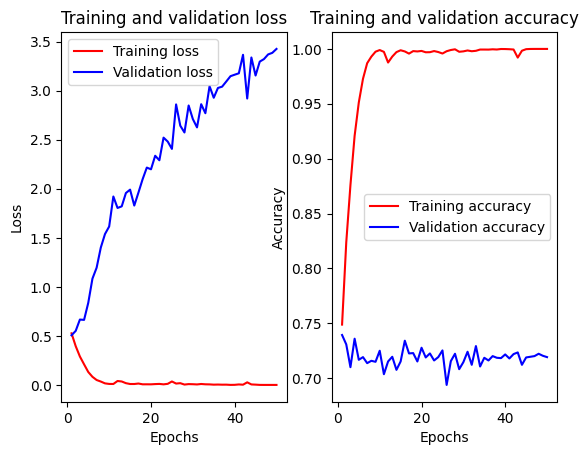

In [16]:
plot_hist_sideways(history_nasnet)

#### MobileNet V2

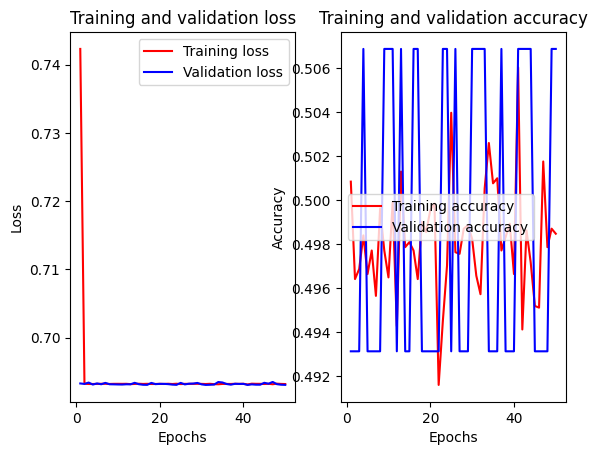

In [17]:
plot_hist_sideways(history_mobile_v2)

#### EfficientNet B0

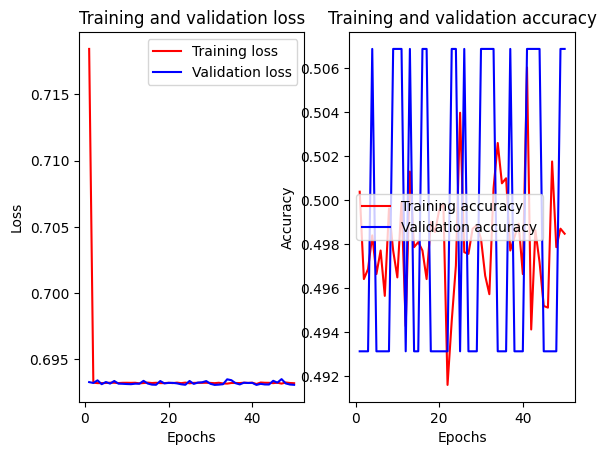

In [18]:
plot_hist_sideways(history_efficient)

## Feature Extraction with multiple passes
Rather than only passing the images through once, we will feed the data through the feature extraction multiple times, we are essentially treating the transfer model as a layer, this allows us to use data augmentation. Since NasNet is way too large for my hardware, I will be using mobilenet and efficient net

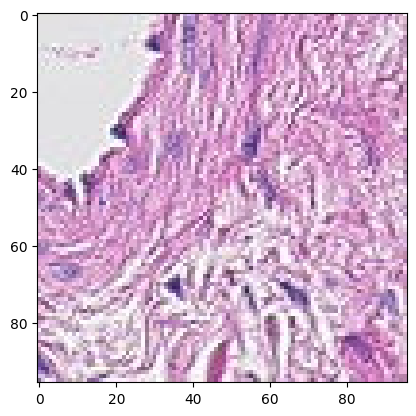

In [19]:
def prep(x):
    return x
imgs, lbs = preprocess_data(train, prep)

img = imgs[3]
plt.imshow(img)

EPOCHS = 25


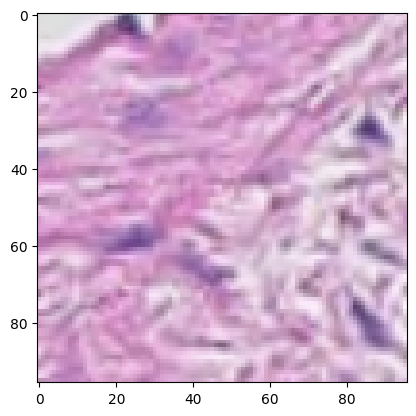

In [20]:
aug_img = augment_layer(flip = "horizontal_and_vertical", rotation=0.5, zoom = 0.4, contrast = 0.5)(img)
plt.imshow(aug_img)

### EfficientNet B0

In [23]:
# Build classifer
inputs = Input(shape = (96, 96, 3))
x = augment_layer(flip = "horizontal_and_vertical", rotation=0.5, zoom = 0.4, contrast = 0.5)(inputs)
x =  tf.keras.applications.efficientnet.preprocess_input(x)
x = efficient_ft_extractor(inputs)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_efficient_layer = Model(inputs = inputs, outputs = output)

# Compile model
m_efficient_layer.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

In [24]:
history_efficient_layer = m_efficient_layer.fit(train, validation_data = val, epochs = EPOCHS)

Epoch 1/25
820/820 [==============================] - 193s 229ms/step - loss: 0.7215 - accuracy: 0.5044 - val_loss: 0.6936 - val_accuracy: 0.4931
Epoch 2/25
820/820 [==============================] - 187s 228ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6935 - val_accuracy: 0.4931
Epoch 3/25
820/820 [==============================] - 187s 228ms/step - loss: 0.6933 - accuracy: 0.5011 - val_loss: 0.6935 - val_accuracy: 0.4931
Epoch 4/25
820/820 [==============================] - 187s 229ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.4931
Epoch 5/25
820/820 [==============================] - 187s 228ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6935 - val_accuracy: 0.4931
Epoch 6/25
820/820 [==============================] - 187s 228ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6935 - val_accuracy: 0.4931
Epoch 7/25
820/820 [==============================] - 188s 229ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6935 -

### Plot results

#### MobileNet

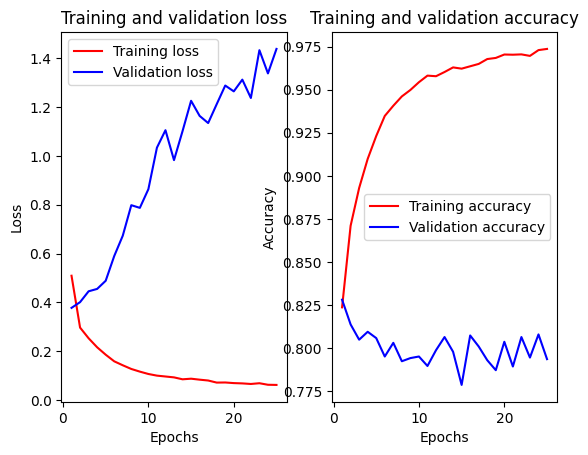

In [25]:
plot_hist_sideways(history_mobile_layer)

#### EfficientNet

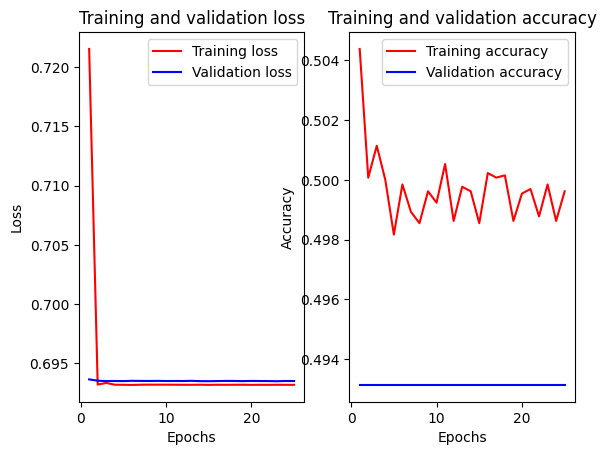

In [26]:
plot_hist_sideways(history_efficient_layer)

## Fine Tuning

In [37]:
with open('nasnetsummary.txt', 'w') as f:

    NasNet_ft_extractor.summary(print_fn=lambda x: f.write(x + '\n'))

with open('mobilesummary.txt', 'w') as f:

    mobilev2_ft_extractor.summary(print_fn=lambda x: f.write(x + '\n'))

In [50]:
# Make last 20 layers trainable
for layer in mobilev2_ft_extractor.layers[-20 : -1]:
    layer.trainable = True

In [52]:
history_fine_tune = m_mobile_layer.fit(train, validation_data= val, epochs = 10)

Epoch 1/10
820/820 [==============================] - 128s 156ms/step - loss: 0.0519 - accuracy: 0.9784 - val_loss: 1.5226 - val_accuracy: 0.8120
Epoch 2/10
820/820 [==============================] - 125s 152ms/step - loss: 0.0485 - accuracy: 0.9798 - val_loss: 1.4895 - val_accuracy: 0.7965
Epoch 3/10
820/820 [==============================] - 126s 154ms/step - loss: 0.0491 - accuracy: 0.9798 - val_loss: 1.6682 - val_accuracy: 0.7849
Epoch 4/10
820/820 [==============================] - 118s 143ms/step - loss: 0.0528 - accuracy: 0.9786 - val_loss: 1.4912 - val_accuracy: 0.7934
Epoch 5/10
820/820 [==============================] - 113s 138ms/step - loss: 0.0489 - accuracy: 0.9800 - val_loss: 1.5360 - val_accuracy: 0.8013
Epoch 6/10
820/820 [==============================] - 114s 139ms/step - loss: 0.0418 - accuracy: 0.9831 - val_loss: 1.5760 - val_accuracy: 0.8032
Epoch 7/10
820/820 [==============================] - 114s 139ms/step - loss: 0.0433 - accuracy: 0.9823 - val_loss: 1.5706 -

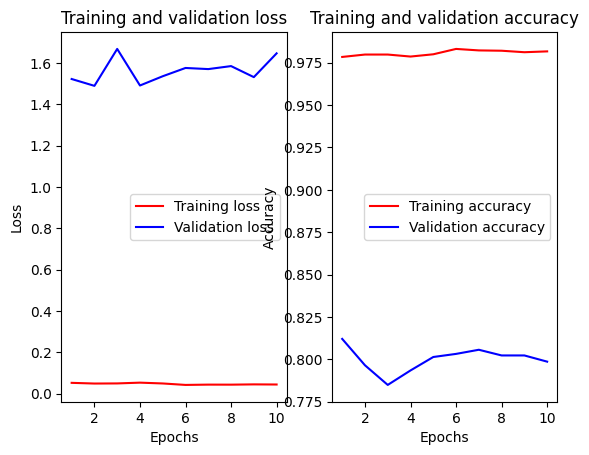

In [54]:
plot_hist_sideways(history_fine_tune)

## Final Results

In [46]:
test_x, test_y = get_features_and_labels(test, NasNet_ft_extractor, tf.keras.applications.efficientnet.preprocess_input)
m_nasnet.evaluate(x = test_x, y = test_y)

103/103 [==============================] - 1s 6ms/step - loss: 4.6737 - accuracy: 0.7000


[4.673676490783691, 0.700030505657196]

In [55]:
m_mobile_layer.evaluate(test)

103/103 [==============================] - 14s 132ms/step - loss: 2.3014 - accuracy: 0.7644


[2.301438570022583, 0.7644186615943909]